In [4]:
from utils import read_ensembl
from config import ENSEMBL_FPATH, ATTR_FNAMES, TEXTWIDTH_INCH, SAVEFIG_KWARGS
import config
import h5py
from pyhere import here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from contextlib import contextmanager
import matplotlib.pyplot as plt

@contextmanager
def journal_plotting_ctx():
    """
    A context manager to temporarily apply specific plotting parameters for matplotlib.
    """
    # Save the current rcParams
    original_rc = plt.rcParams.copy()
    
    # Define the desired parameters
    SMALL_SIZE = 5
    MEDIUM_SIZE = 6
    BIGGER_SIZE = 7

    try:
        # Apply the desired rc settings
        plt.rc('font', size=SMALL_SIZE, family='arial')  # Default font sizes and family
        plt.rc('axes', titlesize=BIGGER_SIZE, labelsize=SMALL_SIZE)  # Axes sizes
        plt.rc('xtick', labelsize=SMALL_SIZE)  # Tick label sizes
        plt.rc('ytick', labelsize=SMALL_SIZE)
        plt.rc('legend', fontsize=SMALL_SIZE, title_fontsize=BIGGER_SIZE)  # Legend sizes
        plt.rc('figure', titlesize=BIGGER_SIZE)  # Figure title size
        plt.rcParams['svg.fonttype'] = 'none'  # SVG fonttype

        # Yield control to the block of code
        yield
    finally:
        # Restore original rcParams
        plt.rcParams.update(original_rc)

In [6]:
ensembl_df = read_ensembl(ENSEMBL_FPATH)

In [7]:
for fname in ATTR_FNAMES:
    with h5py.File(here('data', 'results', 'interpretability', fname), 'r') as h5:
        print(h5, 'Col1a2' in set(ensembl_df.set_index('transcript').loc[h5['transcript'][:].astype(str)].symbol.values))

<HDF5 file "241126_RDHPLG_extraLong_int.h5" (mode r)> False
<HDF5 file "241001_RDHPLG_test_int.h5" (mode r)> False
<HDF5 file "241022_RDHPLG_train_int.h5" (mode r)> True
<HDF5 file "241029_RDHPLG_val_int.h5" (mode r)> False
<HDF5 file "241105_RDHPLG_extra_int.h5" (mode r)> False


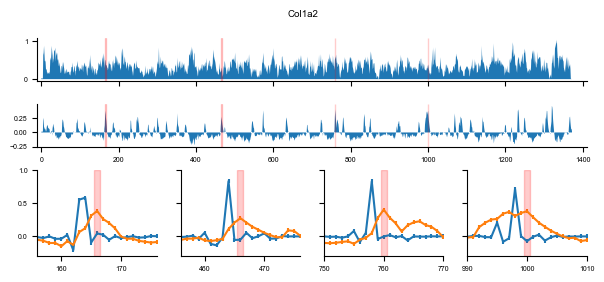

In [8]:
fname = '241022_RDHPLG_train_int.h5'
fpath = here('data', 'results', 'interpretability', fname)
fhandle = h5py.File(fpath, 'r')

gene_symbol = 'Col1a2'
trans_ensembl = ensembl_df.query('symbol == @gene_symbol').transcript # list[str]
transc_idx = ((np.isin(fhandle['transcript'][:].astype(str), trans_ensembl)) & (fhandle['condition'][:].astype('str') == 'VAL')).nonzero()[0][0]

y_true_ctrl = fhandle['y_true_ctrl'][transc_idx]
y_pred_ctrl = fhandle['y_pred_ctrl'][transc_idx]

y_true_depr = fhandle['y_true_dd'][transc_idx]
y_pred_depr = fhandle['y_pred_depr_diff'][transc_idx]

y_true_full = fhandle['y_true_full'][transc_idx]
y_pred_full = fhandle['y_pred_full'][transc_idx]

n_codons = len(y_true_ctrl)

attr_ctrl = fhandle['lig_ctrl'][transc_idx].reshape(n_codons, n_codons)
attr_depr = fhandle['lig_dd'][transc_idx].reshape(n_codons, n_codons)

ratio = 2.5
width = TEXTWIDTH_INCH
height = TEXTWIDTH_INCH / ratio

asites = [166, 466, 760, 1000]
with journal_plotting_ctx():
    fig = plt.figure(figsize=(width, height))
    gs = fig.add_gridspec(3, 4, hspace=.4, height_ratios=[.25,.25,.5])

    ax = fig.add_subplot(gs[0, :])
    ax.fill_between(np.arange(n_codons), np.nan_to_num(y_pred_ctrl, 0))
    ax.set_xlim(-10, 1410)
    ax.set_xticklabels([])
    for a in asites: plt.axvspan(a-.5, a+.5, color='red', alpha=0.2)

    ax = fig.add_subplot(gs[1, :])
    ax.fill_between(np.arange(n_codons), np.nan_to_num(y_pred_depr, 0))
    ax.set_xlim(-10, 1410)
    for a in asites: plt.axvspan(a-.5, a+.5, color='red', alpha=0.2)

    ylim = (-.3, 1)
    nup_cdn = 10
    ndown_cdn = 10
    
    for idx, asite in enumerate(asites):
        ax = fig.add_subplot(gs[2, idx])
        codon_attr = attr_depr[asite, :]
        ax.plot(np.arange(n_codons), np.nan_to_num(codon_attr, 0))
        ax.scatter(np.arange(n_codons), np.nan_to_num(codon_attr, 0), s=5, marker="|")

        ax.plot(np.arange(n_codons), np.nan_to_num(y_pred_depr, 0))
        ax.scatter(np.arange(n_codons), np.nan_to_num(y_pred_depr, 0), s=5, marker="|")

        plt.axvspan(asite-.5, asite+.5, color='red', alpha=0.2)
        ax.set_xlim(asite-nup_cdn, asite+ndown_cdn)
        ax.set_ylim(ylim)
        if idx>0: ax.set_yticklabels([])

    sns.despine()

    fig.suptitle('Col1a2')

    plt.savefig(here('data', 'results', 'figures', 'figure5.pdf'), **config.SAVEFIG_KWARGS)
fhandle.close()